In [2]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import time
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [9]:
EPSILON = 10e-10
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    #chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    raw_mel = librosa.feature.melspectrogram(X, sr=sample_rate).T
    mel = np.mean(raw_mel, axis=0)
    processed_mel = raw_mel + EPSILON
    logMel = np.mean(np.log(processed_mel),axis=0)
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,logMel, mel

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels, namePath = np.empty((0,296)), np.empty(0), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, logmel, mel = extract_feature(fn)
            ext_features = np.hstack([mfccs,logmel, mel])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[-1].split('-')[1])
            namePath = np.append(namePath, fn)
    return np.array(features), np.array(labels, dtype = np.int), np.array(namePath, dtype=np.string_)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

def one_hot_decode(labels):
    n_labels, n_unique_labels = np.shape(labels)
    one_hot_decode = np.zeros((n_labels))
    for idx in range(n_labels):
        for l in range(n_unique_labels):
            if(labels[idx, l] == 1):
                one_hot_decode[idx] = l
                break;
    return one_hot_decode

In [6]:
x = extract_feature("../../data/UrbanSound8K/audio/fold1/7061-6-0-0.wav")
nfMfccs = np.shape(x[0])[0]
nfLogMel = np.shape(x[1])[0]
nfMel = np.shape(x[2])[0]

In [7]:
print "Number of features"
print "* Mfcc: {0}".format(nfMfccs)
print "* logMel {0}".format(nfLogMel)
print "* Mel {0}".format(nfMel)

Number of features
* Mfcc: 40
* logMel 128
* Mel 128


In [10]:
parent_dir = '../../data/UrbanSound8K/audio/'
sub_dirs = ['fold1']
print "---Extracting features.... ---"
start_time = time.time()
features, labels, file_names = parse_audio_files(parent_dir,sub_dirs)
print "---Loading time: {0} seconds ---".format(time.time() - start_time)

---Extracting features.... ---
---Loading time: 181.867201805 seconds ---


In [11]:
one_hot_labels = one_hot_encode(labels)

In [8]:
np.save("nn_features_fold_full", features, allow_pickle=True)

In [9]:
np.save("nn_labels_fold_full", labels, allow_pickle=True)

In [10]:
np.save("nn_file_names_fold_full", file_names, allow_pickle=True)

-------------------------------------------------------------------------------------------------------------------------

### Training Neural Network with TensorFlow

In [11]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

--------------------------------------------------------------------------------------------------------------------------

In [12]:
# Initialize parameters
training_epochs = 20000 # number of iteration
n_dim = 168 # number of features
n_classes = 10 # number of classes
n_hidden_units_one = 280  # number of units in hidden layer 1
n_hidden_units_two = 300 # number of units in hidden layer 2
sd = 1 / np.sqrt(n_dim) # std of initial weight and bias
learning_rate = 0.01 

In [13]:
# Randomly initialize params for each layers
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

# Hidden layer 1 params
W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

# Hidden layer 2 params
W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

# Softmax classification initialization
W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)


init = tf.global_variables_initializer()

In [14]:
# cost_function = 
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Train/Test split 70/30

In [15]:
from sklearn.cross_validation import train_test_split

In [16]:
logmel_features_and_filenames = np.concatenate((features[:,:168], file_names[:,np.newaxis]), axis=1)

In [17]:
train_x1, test_x1, train_y, test_y = train_test_split(logmel_features_and_filenames, labels, test_size=0.3, random_state=5, stratify=xlabels)

In [18]:
train_x = train_x1[:,0:-1]
test_x = test_x1[:,0:-1]

--- Start Training ---
Training.......
------ Elapsed time -------  Iter ---- Cost 
------   0.36469007 -------     0 ---- 2.47950434685 
------ 282.95200896 -------  1000 ---- 1.36340332031 
------ 569.40871692 -------  2000 ---- 1.09253227711 
------ 854.17194200 -------  3000 ---- 0.919654488564 
------ 1138.71639109 -------  4000 ---- 0.814878702164 
------ 1417.81138015 -------  5000 ---- 0.709281265736 
------ 1700.37577605 -------  6000 ---- 0.630629301071 
------ 1978.49579096 -------  7000 ---- 0.577045977116 
------ 2255.07964611 -------  8000 ---- 0.55031144619 
------ 2531.96946692 -------  9000 ---- 0.498961120844 
------ 2811.70468593 ------- 10000 ---- 0.445098161697 
------ 3103.73920107 ------- 11000 ---- 0.399647682905 
------ 3396.65635204 ------- 12000 ---- 0.431312531233 
------ 3686.14057302 ------- 13000 ---- 0.326024830341 
------ 3979.84626603 ------- 14000 ---- 0.308897703886 
------ 4260.68309093 ------- 15000 ---- 0.28558743 
------ 4546.88011408 ------- 160

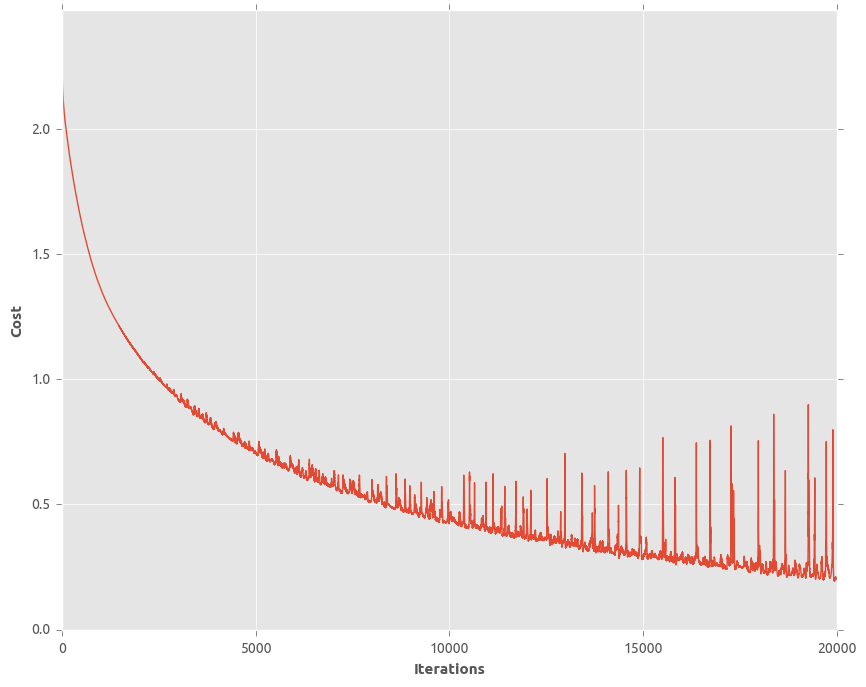

F-Score: 0.860687022901
Confusion Matrix
[[277   0   6   2   0   1   0   4   1   9]
 [  1 110   0   4   2   3   0   6   0   3]
 [  5   1 241  22   5   7   1   0   0  18]
 [  4   2  18 245   8   6   2   2   7   6]
 [  2   0   6  13 266   2   1   6   0   4]
 [  1   0   7   4   1 283   0   0   1   3]
 [  1   0   4  23   2   0  77   0   2   3]
 [  1   0   1   0   8   0   0 289   0   1]
 [  3   1   8  25   0   0   1   1 236   4]
 [ 10   3  21  13   9   5   2   3   3 231]]
---Training time: 5716.54432011 seconds ---
------------------------------------------


In [57]:
training_epochs = 20000 # number of iteration
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
print "--- Start Training ---"
print "Training......."
print "------ Elapsed time -------  Iter ---- Cost "
start_time = time.time()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
        if(epoch % 1000 == 0):
            print "------ {:12.7f} ------- {:5d} ---- {:12.10f} ".format((time.time() - start_time), epoch, cost)
           
    fig = plt.figure(figsize=(10,8))
    plt.plot(cost_history)
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.show()
    save_path = saver.save(sess,"model/nn_model_full.ckpt")
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)
print "---Training time: {0} seconds ---".format((time.time() - start_time))
print "------------------------------------------"

### Error Analysis

In [58]:
classID = {
    0: "AirCon",
    1: "Car horn",
    2: "Children playing",
    3: "Dog bark",
    4: "Drilling",
    5: "Engine idling",
    6: "Gun shot",
    7: "Jackhammer",
    8: "Siren",
    9: "Street music"
}

In [70]:
for ID, name in classID.items():
    x = y_pred[(y_true == ID)*(y_pred != ID)]
    names = test_x1[(y_true == ID)*(y_pred != ID)][:,-1]
    
    unique_class, unique_count = np.unique(x, return_counts=True)
    print "************************************************"
    print " Class {0} is mistaken with: ".format(name)
    for c, y in zip(unique_class, unique_count):        
        print "# {0}: {1} samples".format(classID[c], y)
        for name in names[x == c]:
            true_name = "/".join((name.split("/")[1], name.split("/")[2].split(".")[0]))
            print "--- {0}".format(true_name)
print "************************************************"

************************************************
 Class AirCon is mistaken with: 
# Children playing: 6 samples
--- fold3/159761-0-0-5
--- fold3/159761-0-0-2
--- fold3/159761-0-0-1
--- fold6/184805-0-0-121
--- fold3/159761-0-0-4
--- fold8/74677-0-0-0
# Dog bark: 2 samples
--- fold7/35382-0-0-1
--- fold1/57320-0-0-27
# Engine idling: 1 samples
--- fold3/58806-0-0-0
# Jackhammer: 4 samples
--- fold1/50901-0-1-0
--- fold1/50901-0-0-0
--- fold3/177742-0-0-99
--- fold3/177742-0-0-214
# Siren: 1 samples
--- fold5/85569-0-0-9
# Street music: 9 samples
--- fold6/184805-0-0-40
--- fold9/79089-0-0-4
--- fold5/178686-0-0-53
--- fold6/184805-0-0-32
--- fold9/79089-0-0-115
--- fold7/189981-0-0-16
--- fold9/79089-0-0-6
--- fold6/184805-0-0-51
--- fold5/178686-0-0-34
************************************************
 Class Car horn is mistaken with: 
# AirCon: 1 samples
--- fold2/145577-1-0-0
# Dog bark: 4 samples
--- fold4/7389-1-4-3
--- fold7/99812-1-3-0
--- fold7/14524-1-0-0
--- fold5/185436-1-6-0


### Test

In [73]:
import pandas as pd

In [129]:
test_label_df = pd.read_csv("test_csv.csv")
test_label_df = test_label_df.iloc[:,1:3]
test_label_df.head()

,File name,Label
0,test_sound/90013__thfc140491__jackhammer-vehic...,7
1,test_sound/Tornado Siren-SoundBible.com-897026...,8
2,test_sound/M1 Garand Gunfire-SoundBible.com-69...,6
3,test_sound/Dog Woof-SoundBible.com-457935112.wav,3
4,test_sound/73623__robinhood76__01063-roadworks...,4


In [131]:
def parse_audio_test_files(parent_dir,sub_dir="",file_ext='*.wav'):
    features, namePath = np.empty((0,296)), np.empty(0)
    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        mfccs, logmel, mel = extract_feature(fn)
        ext_features = np.hstack([mfccs,logmel, mel])
        features = np.vstack([features,ext_features])
        namePath = np.append(namePath, fn)
    return np.array(features), np.array(namePath, dtype=np.string_)

In [132]:
test_features, test_fileNames = parse_audio_test_files("test_sound")


In [1]:
test_label_np = test_label_df.as_matrix(["Label"])
test_x = test_features[:,0:168]
test_y = one_hot_encode(test_label_np[:,0])
col10 = np.zeros(76)

NameError: name 'test_label_df' is not defined

In [160]:
test_y = np.concatenate((test_y, col10[:,np.newaxis]), axis=1)

In [162]:
with tf.Session() as sess:
    saver.restore(sess,"model/nn_model_full.ckpt")
    print "Test"
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)

Test
F-Score: 0.328947368421
Confusion Matrix
[[0 0 0 3 1 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 2]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 4 0 0 1 0 0 0]
 [3 0 1 0 5 1 0 3 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 2 5 0 2 1 0 0 3]
 [0 0 0 0 0 0 0 9 0 1]
 [0 2 2 5 4 2 2 1 4 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [164]:
for ID, name in classID.items():
    x = y_pred[(y_true == ID)*(y_pred != ID)]
    names = test_fileNames[(y_true == ID)*(y_pred != ID)]
    
    unique_class, unique_count = np.unique(x, return_counts=True)
    print "************************************************"
    print " Class {0} is mistaken with: ".format(name)
    for c, y in zip(unique_class, unique_count):        
        print "# {0}: {1} samples".format(classID[c], y)
        for name in names[x == c]:
            print "--- {0}".format(true_name)
print "************************************************"

************************************************
 Class AirCon is mistaken with: 
# Dog bark: 3 samples
--- fold8/194733-9-0-12
--- fold8/194733-9-0-12
--- fold8/194733-9-0-12
# Drilling: 1 samples
--- fold8/194733-9-0-12
# Jackhammer: 1 samples
--- fold8/194733-9-0-12
# Street music: 1 samples
--- fold8/194733-9-0-12
************************************************
 Class Car horn is mistaken with: 
# Street music: 2 samples
--- fold8/194733-9-0-12
--- fold8/194733-9-0-12
************************************************
 Class Children playing is mistaken with: 
************************************************
 Class Dog bark is mistaken with: 
# Children playing: 1 samples
--- fold8/194733-9-0-12
# Gun shot: 1 samples
--- fold8/194733-9-0-12
************************************************
 Class Drilling is mistaken with: 
# AirCon: 3 samples
--- fold8/194733-9-0-12
--- fold8/194733-9-0-12
--- fold8/194733-9-0-12
# Children playing: 1 samples
--- fold8/194733-9-0-12
# Engine idling:

### NN - mfcc + mel spec norm_data

In [ ]:
norm_mfcc_mel_features = (mfcc_mel_features - np.mean(mfcc_mel_features, axis=0))/np.std(mfcc_mel_features, axis=0)

In [ ]:
norm_mfcc_mel_features_and_filenames = np.concatenate((norm_mfcc_mel_features, file_names[:,np.newaxis]), axis=1)

In [ ]:
train_x1, test_x1, train_y, test_y = train_test_split(norm_mfcc_mel_features_and_filenames, labels, test_size=0.3, random_state=5, stratify=xlabels)
train_x = train_x1[:,0:-1]
test_x = test_x1[:,0:-1]

In [ ]:
# Initialize parameters
training_epochs = 20000 # number of iteration
n_dim = train_x.shape[1] # number of features
n_classes = 10 # number of classes
n_hidden_units_one = 280  # number of units in hidden layer 1
n_hidden_units_two = 300 # number of units in hidden layer 2
sd = 1 / np.sqrt(n_dim) # std of initial weight and bias
learning_rate = 0.01 

In [ ]:
# Randomly initialize params for each layers
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

# Hidden layer 1 params
W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

# Hidden layer 2 params
W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

# Softmax classification initialization
W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [ ]:
# cost_function = 
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
training_epochs = 20000 # number of iteration
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
     
    fig = plt.figure(figsize=(10,8))
    plt.plot(cost_history)
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.show()
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)
print ("---Training time: %s seconds ---" % (time.time() - start_time))
print "------------------------------------------"

## NN - mfcc + mel spec data

In [ ]:
mfcc_mel_features_and_filenames = np.concatenate((mfcc_mel_features, file_names[:,np.newaxis]), axis=1)
train_x1, test_x1, train_y, test_y = train_test_split(mfcc_mel_features_and_filenames, labels, test_size=0.3, random_state=5, stratify=xlabels)
train_x = train_x1[:,0:-1]
test_x = test_x1[:,0:-1]

In [ ]:
training_epochs = 20000 # number of iteration
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
     
    fig = plt.figure(figsize=(10,8))
    plt.plot(cost_history)
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.show()
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)
print ("---Training time: %s seconds ---" % (time.time() - start_time))
print "------------------------------------------"

In [ ]:
mfcc_logmel_features = np.copy(mfcc_mel_features)
mfcc_logmel_features[:,40:168] = np.log(mfcc_logmel_features[:,40:168] )
mfcc_logmel_features_and_filenames = np.concatenate((mfcc_logmel_features, file_names[:,np.newaxis]), axis=1)
train_x1, test_x1, train_y, test_y = train_test_split(mfcc_logmel_features_and_filenames, labels, test_size=0.3, random_state=5, stratify=xlabels)
train_x = train_x1[:,0:-1]
test_x = test_x1[:,0:-1]

In [ ]:
training_epochs = 20000 # number of iteration
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
     
    fig = plt.figure(figsize=(10,8))
    plt.plot(cost_history)
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.show()
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score: {0}".format(f)
    print "Confusion Matrix"
    print confusion_matrix(y_true, y_pred)
print ("---Training time: %s seconds ---" % (time.time() - start_time))
print "------------------------------------------"